(0.5, -0.2662845623360456)


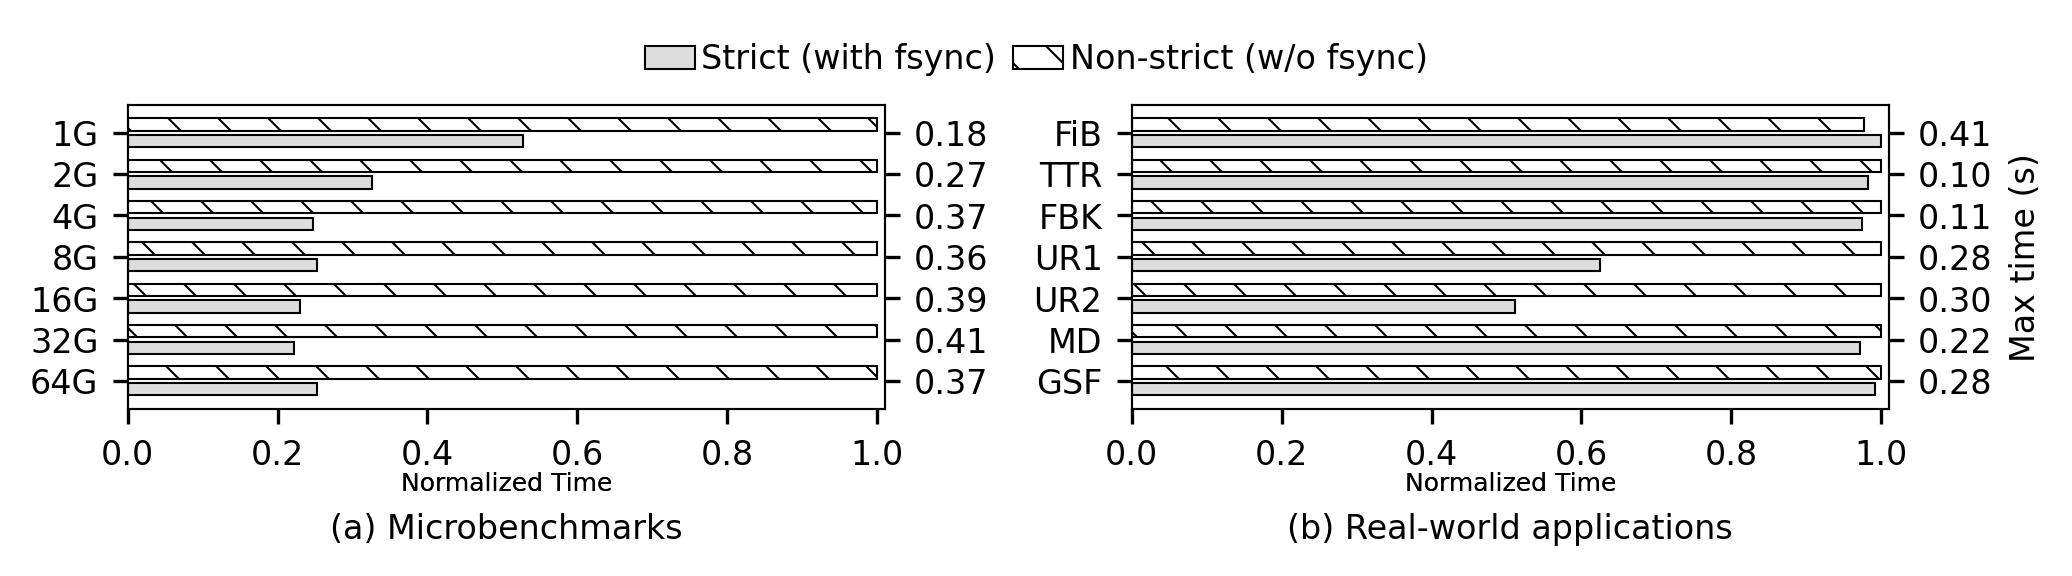

In [28]:
# ipython -c "%run plot.ipynb"

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import matplotlib.gridspec as gridspec


# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
plt.rcParams.update(plt.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = False
%matplotlib inline
style.use('grayscale')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "y"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["hatch.color"] = "black"
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Data Preprocessing
# with open("./avg-test-result-in-paper", "r") as f:
with open("./performance-comparison-table", "r") as f:
    df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

orig_df = df.copy()
# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(4)))
fig.patch.set_facecolor('white')
bar_width = 0.4
true_bar_width = 0.3
subfig_titles = ["(a) Non-strict trace replay", "(b) Strict trace replay"]
patterns = ['///', '\\\\\\', '', 'XXX', 'OOO', '---', '+++']
# Reference: https://designbro.com/blog/inspiration/color-combinations/
colors = [ "#dddddd", "#ffffff"]
cmap = "tab10"
fss = df['file_system'].drop_duplicates().reset_index().drop(columns=['index'])['file_system']
workloads = [ "fio-1024", "fio-2048", "fio-4096", "fio-8192", "fio-16384", "fio-32768", "fio-65536", "filebench", "twitter", "facebook", "usr1", "usr2", "moodle", "gsf-filesrv" ]
workloads_name_remap = [ "1G", "2G", "4G", "8G", "16G", "32G", "64G", "FiB", "TTR", "FBK", "UR1", "UR2", "MD", "GSF" ]

tot = 2 * bar_width
x = list(range(1, len(workloads) + 1))

bars = []
modes = [ "non-strict", "strict" ]
# subfig = plt.subplot(2, 1, fig_idx + 1)
# for idx, fs in enumerate(fss):

for workload in workloads:
    max_time = max([df[(df['workloads'] == workload + "-non-strict")]['real(s)'].iloc[0], df[(df['workloads'] == workload + "-strict")]['real(s)'].iloc[0]])
    orig_workload = workload
    for mode in modes:
        workload = orig_workload + "-" + mode 
        value = df[(df['workloads'] == workload)]['real(s)'] / max_time
        error = df[(df['workloads'] == workload)]['std-real(s)'] / max_time
        df.loc[(df['workloads'] == workload), 'real(s)'] = value
        df.loc[(df['workloads'] == workload), 'std-real(s)'] = error


def add_explanation_and_title(fig, ax, exp, title, title_pad=10, title_fontsize=8, exp_fontsize=6):
    lable_pad = title_pad
    ax.set_xlabel(title, fontsize=title_fontsize, labelpad=lable_pad) 
    return [exp, title, title_pad, title_fontsize, exp_fontsize]
    
def adjust_explanation(fig, axes, context):
    exp, title, title_pad, title_fontsize, exp_fontsize = context
    
    # plt.tight_layout()
    # fig.savefig("./temp.pdf", bbox_inches='tight', pad_inches=0)
    fig.savefig("./temp.pdf", bbox_inches='tight', pad_inches=0)
    # for ax in fig.axes:
        # plt.tight_layout()
        # Get the first xtick label
    midpoint = (0.5, 0.5)
    for idx, ax in enumerate(axes):
        xtick_label = ax.get_xticklabels()[0]
        label_bbox1 = xtick_label.get_window_extent()
        # print(label_bbox1)
        figure_pos1 = label_bbox1.transformed(ax.transAxes.inverted())
        
        # Get the xlabel object
        xlable = ax.xaxis.label
        label_bbox2 = xlable.get_window_extent()
        # print(label_bbox2)
        figure_pos2 = label_bbox2.transformed(ax.transAxes.inverted())
        midpoint = (0.5, (figure_pos1.y0 + figure_pos2.y1) / 2 + 0.08)
        
    print(midpoint)
    for idx, ax in enumerate(axes):
        explanation = ax.text(midpoint[0], midpoint[1], exp, ha='center', fontsize=exp_fontsize, transform=ax.transAxes)   

        # fig.savefig("./temp" + str(idx) + ".pdf", bbox_inches='tight', pad_inches=0)
        # # adjust midpoint
        # explanation_bbox = explanation.get_window_extent().transformed(ax.transAxes.inverted())
        # height = explanation_bbox.height
        # midpoint = (midpoint[0], midpoint[1] + height)
        # explanation.set_position(midpoint)


# bws_error = []
max_bws = []
for idx, workload in enumerate(workloads):
    real_bws = []
    points = []
    pivot = x[idx] 
    for fig_idx, mode in enumerate(modes):
        point = pivot - tot / 2 + bar_width / 2 + fig_idx * bar_width
        # bws.append(df[(df['workloads'] == workload + "-" + mode)]['real(s)'].iloc[0])
        # points.append(point)
        bw = df[(df['workloads'] == workload + "-" + mode)]['real(s)'].iloc[0]
        real_bw = orig_df[(orig_df['workloads'] == workload + "-" + mode)]['real(s)'].iloc[0]
        errorbw = df[(df['workloads'] == workload + "-" + mode)]['std-real(s)'].iloc[0]
        bar = plt.bar(point, bw, width=true_bar_width, edgecolor='black', linewidth=0.5, color=colors[fig_idx], hatch=patterns[fig_idx])
        # plt.errorbar(point, bw, yerr=errorbw, ecolor='black', capsize=2, capthick=0.5, elinewidth=0.5)
        points.append(point)
        real_bws.append(real_bw)
            
        bars.append(bar)

    max_bw = max(real_bws)
    max_bws.append(max_bw)
    # plt.text(pivot, 1 + 0.1, "{:.1f}s".format(max_bw), ha='center', fontsize=6)
    # if bws[0] > 0.8 and bws[1] > 0.8: 
    # elif bws[0] > 0.8 and bws[1] < 0.8:
    #     plt.text(point, bw + 0.05, "{:.2f}s".format(real_bw), ha='center', fontsize=6, rotation=90)

ax = fig.gca()
lw = 0.5
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(lw)

# add_explanation_and_title(fig, subfig, "", subfig_titles[fig_idx], title_pad=0, title_fontsize=8, exp_fontsize=6)
# Draw title
plt.ylim(0, 1.4)
plt.xticks(x, labels=workloads_name_remap, fontsize=8, rotation=45)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=8)
plt.ylabel('Normalized Time (s)', fontsize=8)
# ax.set_xlim(0.5, 15.5)
plt.xlim(0.5, 14.5)
xlim = ax.get_xlim()

ax.twiny()
ax = fig.gca()
lw = 0.5
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(lw)
plt.xticks(x, labels=["." + str((round(bw * 10))) for bw in max_bws], fontsize=8)
ax.set_xlim(xlim)
# ax.set_xlabel("Max time (s)", fontsize=8)

# plt.xlabel(subfig_titles[fig_idx], fontsize=8)

# fss.replace("SplitFS-FILEBENCH", "SplitFS", inplace=True)
# fss.replace("HUNTER", "HUNTER-naive", inplace=True)
# fss.replace("HUNTER-J", "HUNTER", inplace=True)
legend_labels = ["Non-strict (w/o fsync)", "Strict (with fsync)"]

# fig.legend(bars, legend_labels, loc='center', bbox_to_anchor=(0.5, 1.0), ncol=2, fontsize=8, frameon=False, columnspacing=0.5, handletextpad=0.2, borderaxespad=0.1, handlelength=1.5)
fig.legend(bars, legend_labels, loc='upper center', bbox_to_anchor=(0,0,1,1), bbox_transform=ax.transAxes, ncol=2, fontsize=8, frameon=False, columnspacing=0.5, handletextpad=0.2, borderaxespad=0.1, handlelength=1.5, labelspacing=0.1, borderpad=0.2)
plt.tight_layout()
plt.savefig("./FIG-FlushOverheads.pdf", bbox_inches='tight', pad_inches=0)


# Vertical and Horizontal Lines

NameError: name 'add_explanation_and_title' is not defined

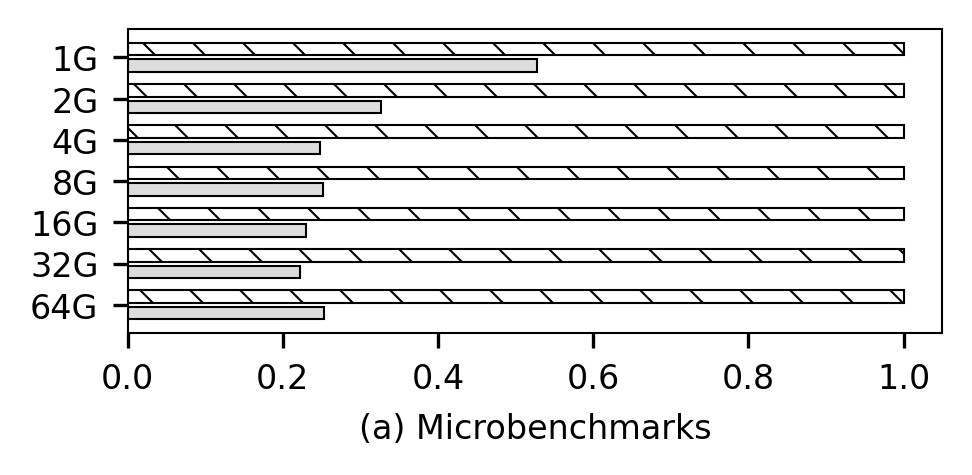

In [1]:
# ipython -c "%run plot.ipynb"

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import matplotlib.gridspec as gridspec


# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
plt.rcParams.update(plt.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = False
%matplotlib inline
style.use('grayscale')
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.grid.axis"] = "y"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["hatch.color"] = "black"
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Data Preprocessing
# with open("./avg-test-result-in-paper", "r") as f:
with open("./performance-comparison-table", "r") as f:
    df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

orig_df = df.copy()
# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(7.5)))
fig.patch.set_facecolor('white')
bar_width = 0.4
true_bar_width = 0.3
subfig_titles = ["(a) Non-strict trace replay", "(b) Strict trace replay"]
patterns = ['', '\\\\', '', 'XXX', 'OOO', '---', '+++']
# Reference: https://designbro.com/blog/inspiration/color-combinations/
colors = [ "#dddddd", "#ffffff"]
cmap = "tab10"
fss = df['file_system'].drop_duplicates().reset_index().drop(columns=['index'])['file_system']
# workloads = [ "fio-512", "fio-1024", "fio-2048", "fio-3072", "fio-4096", "filebench", "twitter", "facebook", "usr1", "usr2", "moodle", "gsf-filesrv" ]
# workloads = [ "filebench", "twitter", "facebook", "usr1", "usr2", "moodle", "gsf-filesrv" ]
# workloads.reverse()

workloads = [ "fio-1024", "fio-2048", "fio-4096", "fio-8192", "fio-16384", "fio-32768", "fio-65536", "filebench", "twitter", "facebook", "usr1", "usr2", "moodle", "gsf-filesrv" ]
workloads_name_remap = [ "1G", "2G", "4G", "8G", "16G", "32G", "64G", "FiB", "TTR", "FBK", "UR1", "UR2", "MD", "GSF" ]

# reserve the first 7 workloads for the first figure
# reserve the last 7 workloads for the second figure
workloads = workloads[7:] + workloads[:7]
workloads_name_remap = workloads_name_remap[7:] + workloads_name_remap[:7] 
workloads.reverse()
workloads_name_remap.reverse()

tot = 2 * bar_width
x = list(range(1, len(workloads) // 2 + 1))

bars = []
modes = [ "strict", "non-strict" ]
# for idx, fs in enumerate(fss):

for workload in workloads:
    max_time = max([df[(df['workloads'] == workload + "-non-strict")]['real(s)'].iloc[0], df[(df['workloads'] == workload + "-strict")]['real(s)'].iloc[0]])
    orig_workload = workload
    for mode in modes:
        workload = orig_workload + "-" + mode 
        value = df[(df['workloads'] == workload)]['real(s)'] / max_time
        error = df[(df['workloads'] == workload)]['std-real(s)'] / max_time
        df.loc[(df['workloads'] == workload), 'real(s)'] = value
        df.loc[(df['workloads'] == workload), 'std-real(s)'] = error
# subfig = plt.subplot(2, 1, fig_idx + 1)


def add_explanation_and_title(fig, ax, exp, title, title_pad=10, title_fontsize=8, exp_fontsize=6):
    lable_pad = title_pad
    ax.set_xlabel(title, fontsize=title_fontsize, labelpad=lable_pad) 
    return [exp, title, title_pad, title_fontsize, exp_fontsize]
    
def adjust_explanation(fig, axes, context):
    exp, title, title_pad, title_fontsize, exp_fontsize = context
    
    # plt.tight_layout()
    # fig.savefig("./temp.pdf", bbox_inches='tight', pad_inches=0)
    fig.savefig("./temp.pdf", bbox_inches='tight', pad_inches=0)
    # for ax in fig.axes:
        # plt.tight_layout()
        # Get the first xtick label
    midpoint = (0.5, 0.5)
    for idx, ax in enumerate(axes):
        xtick_label = ax.get_xticklabels()[0]
        label_bbox1 = xtick_label.get_window_extent()
        # print(label_bbox1)
        figure_pos1 = label_bbox1.transformed(ax.transAxes.inverted())
        
        # Get the xlabel object
        xlable = ax.xaxis.label
        label_bbox2 = xlable.get_window_extent()
        # print(label_bbox2)
        figure_pos2 = label_bbox2.transformed(ax.transAxes.inverted())
        midpoint = (0.5, (figure_pos1.y0 + figure_pos2.y1) / 2 + 0.08)
        
    print(midpoint)
    for idx, ax in enumerate(axes):
        explanation = ax.text(midpoint[0], midpoint[1], exp, ha='center', fontsize=exp_fontsize, transform=ax.transAxes)   

        # fig.savefig("./temp" + str(idx) + ".pdf", bbox_inches='tight', pad_inches=0)
        # # adjust midpoint
        # explanation_bbox = explanation.get_window_extent().transformed(ax.transAxes.inverted())
        # height = explanation_bbox.height
        # midpoint = (midpoint[0], midpoint[1] + height)
        # explanation.set_position(midpoint)


max_bws = []
subfig = plt.subplot(2, 1, 1)
for idx, workload in enumerate(workloads[:7]):
    real_bws = []
    points = []
    pivot = x[idx] 
    for fig_idx, mode in enumerate(modes):
        point = pivot - tot / 2 + bar_width / 2 + fig_idx * bar_width
        # bws.append(df[(df['workloads'] == workload + "-" + mode)]['real(s)'].iloc[0])
        # points.append(point)
        bw = df[(df['workloads'] == workload + "-" + mode)]['real(s)'].iloc[0]
        real_bw = orig_df[(orig_df['workloads'] == workload + "-" + mode)]['real(s)'].iloc[0]
        errorbw = df[(df['workloads'] == workload + "-" + mode)]['std-real(s)'].iloc[0]
        bar = plt.barh(point, bw, height=true_bar_width, edgecolor='black', linewidth=0.5, color=colors[fig_idx], hatch=patterns[fig_idx])
        # plt.errorbar(point, bw, xerr=errorbw, ecolor='black', capsize=2, capthick=0.5, elinewidth=0.5)
        points.append(point)
        real_bws.append(real_bw)
            
        bars.append(bar)

    max_bw = max(real_bws)
    max_bws.append(max_bw)
    # plt.text(pivot, 1 + 0.1, "{:.1f}s".format(max_bw), ha='center', fontsize=6)
    # if bws[0] > 0.8 and bws[1] > 0.8: 
    # elif bws[0] > 0.8 and bws[1] < 0.8:
    # plt.text(1 + 0.05, point,  "{:.2f}s".format(real_bw), ha='center', fontsize=6)

ax = fig.gca()
lw = 0.5
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(lw)

# add_explanation_and_title(fig, subfig, "", subfig_titles[fig_idx], title_pad=0, title_fontsize=8, exp_fontsize=6)
# Draw title
plt.yticks(x, labels=workloads_name_remap[:7], fontsize=8)
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=8)
plt.xlabel('(a) Microbenchmarks', fontsize=8)
ctx = add_explanation_and_title(fig, subfig, "Normalized Time", "(a) Microbenchmarks")
plt.xlim(0, 1.01)
ylim = ax.get_ylim()
adjust_ax1 = ax

ax = ax.twinx()
ax = fig.gca()
lw = 0.5
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(lw)

plt.ylim(ylim)
plt.yticks(x, labels=[ "{:.2f}".format(bw) for bw in max_bws], fontsize=8)
plt.ylabel("Max time (s)", fontsize=8)

max_bws = []
subfig = plt.subplot(2, 1, 2)
for idx, workload in enumerate(workloads[7:]):
    real_bws = []
    points = []
    pivot = x[idx] 
    for fig_idx, mode in enumerate(modes):
        point = pivot - tot / 2 + bar_width / 2 + fig_idx * bar_width
        # bws.append(df[(df['workloads'] == workload + "-" + mode)]['real(s)'].iloc[0])
        # points.append(point)
        bw = df[(df['workloads'] == workload + "-" + mode)]['real(s)'].iloc[0]
        real_bw = orig_df[(orig_df['workloads'] == workload + "-" + mode)]['real(s)'].iloc[0]
        errorbw = df[(df['workloads'] == workload + "-" + mode)]['std-real(s)'].iloc[0]
        bar = plt.barh(point, bw, height=true_bar_width, edgecolor='black', linewidth=0.5, color=colors[fig_idx], hatch=patterns[fig_idx])
        # plt.errorbar(point, bw, xerr=errorbw, ecolor='black', capsize=2, capthick=0.5, elinewidth=0.5)
        points.append(point)
        real_bws.append(real_bw)
            
        bars.append(bar)

    max_bw = max(real_bws)
    max_bws.append(max_bw)
    # plt.text(pivot, 1 + 0.1, "{:.1f}s".format(max_bw), ha='center', fontsize=6)
    # if bws[0] > 0.8 and bws[1] > 0.8: 
    # elif bws[0] > 0.8 and bws[1] < 0.8:
    # plt.text(1 + 0.05, point,  "{:.2f}s".format(real_bw), ha='center', fontsize=6)

ax = fig.gca()
lw = 0.5
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(lw)

# add_explanation_and_title(fig, subfig, "", subfig_titles[fig_idx], title_pad=0, title_fontsize=8, exp_fontsize=6)
# Draw title
plt.yticks(x, labels=workloads_name_remap[7:], fontsize=8)
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=8)
# plt.xlabel('Normalized Time', fontsize=8)
ctx = add_explanation_and_title(fig, subfig, "Normalized Time", "(b) Real-world applications")
plt.xlim(0, 1.01)
ylim = ax.get_ylim()
adjust_ax2 = ax

ax = ax.twinx()
ax = fig.gca()
lw = 0.5
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(lw)

plt.ylim(ylim)
plt.yticks(x, labels=[ "{:.2f}".format(bw) for bw in max_bws], fontsize=8)
plt.ylabel("Max time (s)", fontsize=8)
# plt.ylim(1, 7)
# plt.xlabel(subfig_titles[fig_idx], fontsize=8)

# fss.replace("SplitFS-FILEBENCH", "SplitFS", inplace=True)
# fss.replace("HUNTER", "HUNTER-naive", inplace=True)
# fss.replace("HUNTER-J", "HUNTER", inplace=True)
legend_labels = ["Strict (with fsync)", "Non-strict (w/o fsync)"]

fig.legend(bars, legend_labels, loc='center', bbox_to_anchor=(0.5, 1.0), ncol=2, fontsize=8, frameon=False, columnspacing=0.5, handletextpad=0.2, borderaxespad=0.1, handlelength=1.5)
plt.tight_layout()
adjust_explanation(fig, [adjust_ax1, adjust_ax2], ctx)
plt.savefig("./FIG-FlushOverheads.pdf", bbox_inches='tight', pad_inches=0)


# Merge

(0.5, -0.24251441612922858)


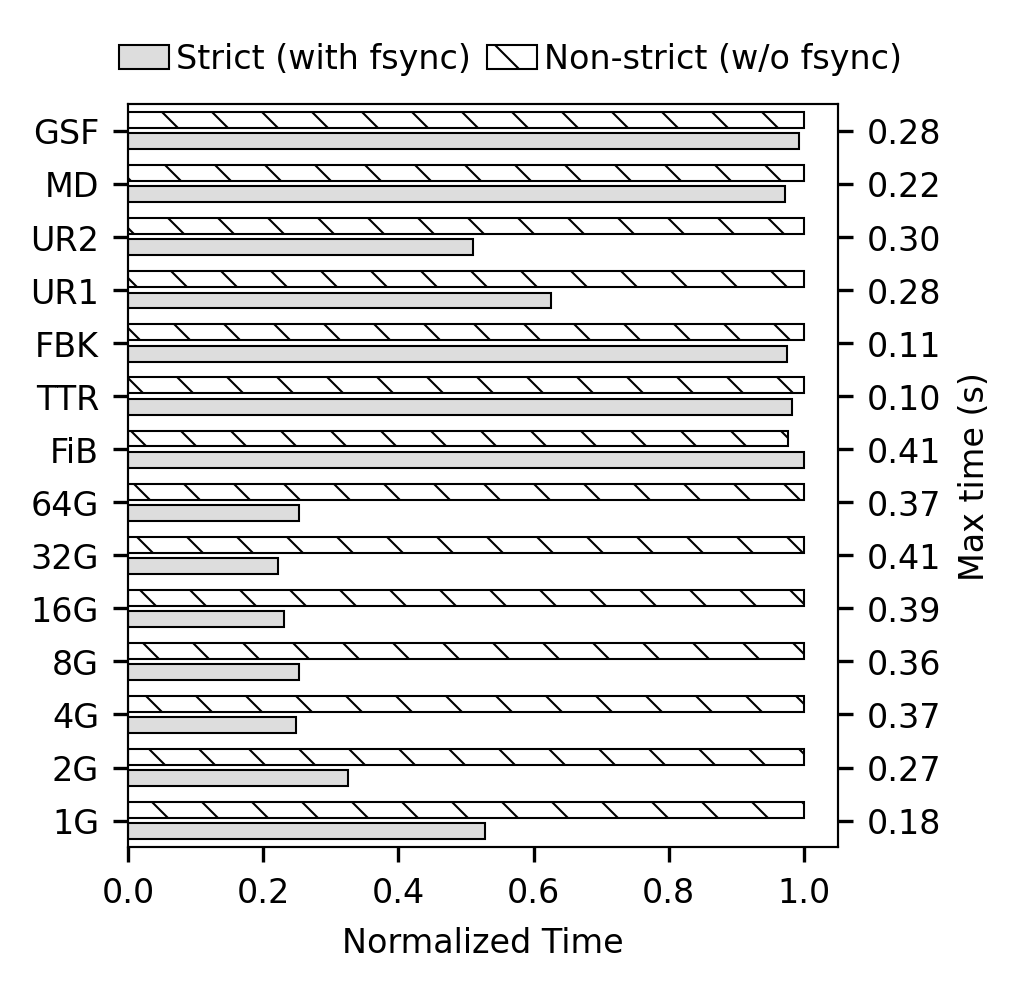

In [30]:
# ipython -c "%run plot.ipynb"

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import matplotlib.gridspec as gridspec


# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
plt.rcParams.update(plt.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = False
%matplotlib inline
style.use('grayscale')
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.grid.axis"] = "y"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["hatch.color"] = "black"
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Data Preprocessing
# with open("./avg-test-result-in-paper", "r") as f:
with open("./performance-comparison-table", "r") as f:
    df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

orig_df = df.copy()
# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(8)))
fig.patch.set_facecolor('white')
bar_width = 0.4
true_bar_width = 0.3
subfig_titles = ["(a) Non-strict trace replay", "(b) Strict trace replay"]
patterns = ['', '\\\\', '', 'XXX', 'OOO', '---', '+++']
# Reference: https://designbro.com/blog/inspiration/color-combinations/
colors = [ "#dddddd", "#ffffff"]
cmap = "tab10"
fss = df['file_system'].drop_duplicates().reset_index().drop(columns=['index'])['file_system']
# workloads = [ "fio-512", "fio-1024", "fio-2048", "fio-3072", "fio-4096", "filebench", "twitter", "facebook", "usr1", "usr2", "moodle", "gsf-filesrv" ]
# workloads = [ "filebench", "twitter", "facebook", "usr1", "usr2", "moodle", "gsf-filesrv" ]
# workloads.reverse()

workloads = [ "fio-1024", "fio-2048", "fio-4096", "fio-8192", "fio-16384", "fio-32768", "fio-65536", "filebench", "twitter", "facebook", "usr1", "usr2", "moodle", "gsf-filesrv" ]
workloads_name_remap = [ "1G", "2G", "4G", "8G", "16G", "32G", "64G", "FiB", "TTR", "FBK", "UR1", "UR2", "MD", "GSF" ]

# reserve the first 7 workloads for the first figure
# reserve the last 7 workloads for the second figure
# workloads = workloads[7:] + workloads[:7]
# workloads_name_remap = workloads_name_remap[7:] + workloads_name_remap[:7] 
# workloads.reverse()
# workloads_name_remap.reverse()

tot = 2 * bar_width
x = list(range(1, len(workloads) + 1))

bars = []
modes = [ "strict", "non-strict" ]
# for idx, fs in enumerate(fss):

for workload in workloads:
    max_time = max([df[(df['workloads'] == workload + "-non-strict")]['real(s)'].iloc[0], df[(df['workloads'] == workload + "-strict")]['real(s)'].iloc[0]])
    orig_workload = workload
    for mode in modes:
        workload = orig_workload + "-" + mode 
        value = df[(df['workloads'] == workload)]['real(s)'] / max_time
        error = df[(df['workloads'] == workload)]['std-real(s)'] / max_time
        df.loc[(df['workloads'] == workload), 'real(s)'] = value
        df.loc[(df['workloads'] == workload), 'std-real(s)'] = error
# subfig = plt.subplot(2, 1, fig_idx + 1)


def add_explanation_and_title(fig, ax, exp, title, title_pad=10, title_fontsize=8, exp_fontsize=6):
    lable_pad = title_pad
    ax.set_xlabel(title, fontsize=title_fontsize, labelpad=lable_pad) 
    return [exp, title, title_pad, title_fontsize, exp_fontsize]
    
def adjust_explanation(fig, axes, context):
    exp, title, title_pad, title_fontsize, exp_fontsize = context
    
    # plt.tight_layout()
    # fig.savefig("./temp.pdf", bbox_inches='tight', pad_inches=0)
    fig.savefig("./temp.pdf", bbox_inches='tight', pad_inches=0)
    # for ax in fig.axes:
        # plt.tight_layout()
        # Get the first xtick label
    midpoint = (0.5, 0.5)
    for idx, ax in enumerate(axes):
        xtick_label = ax.get_xticklabels()[0]
        label_bbox1 = xtick_label.get_window_extent()
        # print(label_bbox1)
        figure_pos1 = label_bbox1.transformed(ax.transAxes.inverted())
        
        # Get the xlabel object
        xlable = ax.xaxis.label
        label_bbox2 = xlable.get_window_extent()
        # print(label_bbox2)
        figure_pos2 = label_bbox2.transformed(ax.transAxes.inverted())
        midpoint = (0.5, (figure_pos1.y0 + figure_pos2.y1) / 2 + 0.08)
        
    print(midpoint)
    for idx, ax in enumerate(axes):
        explanation = ax.text(midpoint[0], midpoint[1], exp, ha='center', fontsize=exp_fontsize, transform=ax.transAxes)   

        # fig.savefig("./temp" + str(idx) + ".pdf", bbox_inches='tight', pad_inches=0)
        # # adjust midpoint
        # explanation_bbox = explanation.get_window_extent().transformed(ax.transAxes.inverted())
        # height = explanation_bbox.height
        # midpoint = (midpoint[0], midpoint[1] + height)
        # explanation.set_position(midpoint)


max_bws = []
# subfig = plt.subplot(2, 1, 1)
for idx, workload in enumerate(workloads):
    real_bws = []
    points = []
    pivot = x[idx] 
    for fig_idx, mode in enumerate(modes):
        point = pivot - tot / 2 + bar_width / 2 + fig_idx * bar_width
        # bws.append(df[(df['workloads'] == workload + "-" + mode)]['real(s)'].iloc[0])
        # points.append(point)
        bw = df[(df['workloads'] == workload + "-" + mode)]['real(s)'].iloc[0]
        real_bw = orig_df[(orig_df['workloads'] == workload + "-" + mode)]['real(s)'].iloc[0]
        errorbw = df[(df['workloads'] == workload + "-" + mode)]['std-real(s)'].iloc[0]
        bar = plt.barh(point, bw, height=true_bar_width, edgecolor='black', linewidth=0.5, color=colors[fig_idx], hatch=patterns[fig_idx])
        # plt.errorbar(point, bw, xerr=errorbw, ecolor='black', capsize=2, capthick=0.5, elinewidth=0.5)
        points.append(point)
        real_bws.append(real_bw)
            
        bars.append(bar)

    max_bw = max(real_bws)
    max_bws.append(max_bw)
    # plt.text(pivot, 1 + 0.1, "{:.1f}s".format(max_bw), ha='center', fontsize=6)
    # if bws[0] > 0.8 and bws[1] > 0.8: 
    # elif bws[0] > 0.8 and bws[1] < 0.8:
    # plt.text(1 + 0.05, point,  "{:.2f}s".format(real_bw), ha='center', fontsize=6)

ax = fig.gca()
lw = 0.5
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(lw)

# add_explanation_and_title(fig, subfig, "", subfig_titles[fig_idx], title_pad=0, title_fontsize=8, exp_fontsize=6)
# Draw title
plt.yticks(x, labels=workloads_name_remap, fontsize=8)
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=8)
plt.xlabel('Normalized Time', fontsize=8)
# ctx = add_explanation_and_title(fig, subfig, "Normalized Time", "(a) Microbenchmarks")
# plt.xlim(0, 1.01)
ax.set_ylim(0.5, 14.5)
ylim = ax.get_ylim()

ax = ax.twinx()
ax = fig.gca()
lw = 0.5
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(lw)

plt.ylim(ylim)
plt.yticks(x, labels=[ "{:.2f}".format(bw) for bw in max_bws], fontsize=8)
plt.ylabel("Max time (s)", fontsize=8)

# max_bws = []
# subfig = plt.subplot(2, 1, 2)
# for idx, workload in enumerate(workloads[7:]):
#     real_bws = []
#     points = []
#     pivot = x[idx] 
#     for fig_idx, mode in enumerate(modes):
#         point = pivot - tot / 2 + bar_width / 2 + fig_idx * bar_width
#         # bws.append(df[(df['workloads'] == workload + "-" + mode)]['real(s)'].iloc[0])
#         # points.append(point)
#         bw = df[(df['workloads'] == workload + "-" + mode)]['real(s)'].iloc[0]
#         real_bw = orig_df[(orig_df['workloads'] == workload + "-" + mode)]['real(s)'].iloc[0]
#         errorbw = df[(df['workloads'] == workload + "-" + mode)]['std-real(s)'].iloc[0]
#         bar = plt.barh(point, bw, height=true_bar_width, edgecolor='black', linewidth=0.5, color=colors[fig_idx], hatch=patterns[fig_idx])
#         # plt.errorbar(point, bw, xerr=errorbw, ecolor='black', capsize=2, capthick=0.5, elinewidth=0.5)
#         points.append(point)
#         real_bws.append(real_bw)
            
#         bars.append(bar)

#     max_bw = max(real_bws)
#     max_bws.append(max_bw)
#     # plt.text(pivot, 1 + 0.1, "{:.1f}s".format(max_bw), ha='center', fontsize=6)
#     # if bws[0] > 0.8 and bws[1] > 0.8: 
#     # elif bws[0] > 0.8 and bws[1] < 0.8:
#     # plt.text(1 + 0.05, point,  "{:.2f}s".format(real_bw), ha='center', fontsize=6)

# ax = fig.gca()
# lw = 0.5
# for axis in ['top','bottom','left','right']:
#     ax.spines[axis].set_linewidth(lw)

# # add_explanation_and_title(fig, subfig, "", subfig_titles[fig_idx], title_pad=0, title_fontsize=8, exp_fontsize=6)
# # Draw title
# plt.yticks(x, labels=workloads_name_remap[7:], fontsize=8)
# plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=8)
# # plt.xlabel('Normalized Time', fontsize=8)
# ctx = add_explanation_and_title(fig, subfig, "Normalized Time", "(b) Real-world applications")
# plt.xlim(0, 1.01)
# ylim = ax.get_ylim()
# adjust_ax = ax

# ax = ax.twinx()
# ax = fig.gca()
# lw = 0.5
# for axis in ['top','bottom','left','right']:
#     ax.spines[axis].set_linewidth(lw)

# plt.ylim(ylim)
# plt.yticks(x, labels=[ "{:.2f}".format(bw) for bw in max_bws], fontsize=8)
# plt.ylabel("Max time (s)", fontsize=8)
# plt.ylim(1, 7)
# plt.xlabel(subfig_titles[fig_idx], fontsize=8)

# fss.replace("SplitFS-FILEBENCH", "SplitFS", inplace=True)
# fss.replace("HUNTER", "HUNTER-naive", inplace=True)
# fss.replace("HUNTER-J", "HUNTER", inplace=True)
legend_labels = ["Strict (with fsync)", "Non-strict (w/o fsync)"]

fig.legend(bars, legend_labels, loc='center', bbox_to_anchor=(0.5, 1), ncol=2, fontsize=8, frameon=False, columnspacing=0.5, handletextpad=0.2, borderaxespad=0.1, handlelength=1.5)
plt.tight_layout()
adjust_explanation(fig, [adjust_ax], ctx)
plt.savefig("./FIG-FlushOverheads.pdf", bbox_inches='tight', pad_inches=0)


# Vertical Style

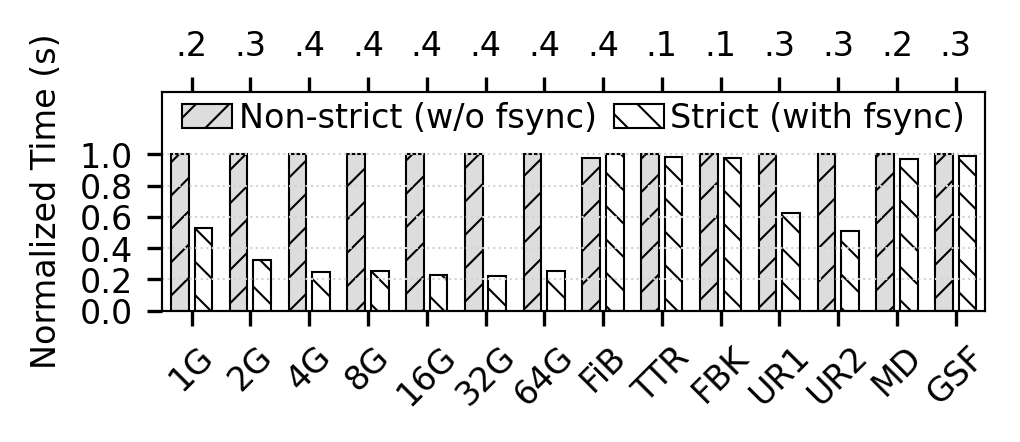

In [3]:
# ipython -c "%run plot.ipynb"

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import matplotlib.gridspec as gridspec


# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
plt.rcParams.update(plt.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = False
%matplotlib inline
style.use('grayscale')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "y"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["hatch.color"] = "black"
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Data Preprocessing
# with open("./avg-test-result-in-paper", "r") as f:
with open("./performance-comparison-table", "r") as f:
    df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

orig_df = df.copy()
# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(4)))
fig.patch.set_facecolor('white')
bar_width = 0.4
true_bar_width = 0.3
subfig_titles = ["(a) Non-strict trace replay", "(b) Strict trace replay"]
patterns = ['///', '\\\\\\', '', 'XXX', 'OOO', '---', '+++']
# Reference: https://designbro.com/blog/inspiration/color-combinations/
colors = [ "#dddddd", "#ffffff"]
cmap = "tab10"
fss = df['file_system'].drop_duplicates().reset_index().drop(columns=['index'])['file_system']
workloads = [ "fio-1024", "fio-2048", "fio-4096", "fio-8192", "fio-16384", "fio-32768", "fio-65536", "filebench", "twitter", "facebook", "usr1", "usr2", "moodle", "gsf-filesrv" ]
workloads_name_remap = [ "1G", "2G", "4G", "8G", "16G", "32G", "64G", "FiB", "TTR", "FBK", "UR1", "UR2", "MD", "GSF" ]

tot = 2 * bar_width
x = list(range(1, len(workloads) + 1))

bars = []
modes = [ "non-strict", "strict" ]
# subfig = plt.subplot(2, 1, fig_idx + 1)
# for idx, fs in enumerate(fss):

for workload in workloads:
    max_time = max([df[(df['workloads'] == workload + "-non-strict")]['real(s)'].iloc[0], df[(df['workloads'] == workload + "-strict")]['real(s)'].iloc[0]])
    orig_workload = workload
    for mode in modes:
        workload = orig_workload + "-" + mode 
        value = df[(df['workloads'] == workload)]['real(s)'] / max_time
        error = df[(df['workloads'] == workload)]['std-real(s)'] / max_time
        df.loc[(df['workloads'] == workload), 'real(s)'] = value
        df.loc[(df['workloads'] == workload), 'std-real(s)'] = error

# bws_error = []
max_bws = []
for idx, workload in enumerate(workloads):
    real_bws = []
    points = []
    pivot = x[idx] 
    for fig_idx, mode in enumerate(modes):
        point = pivot - tot / 2 + bar_width / 2 + fig_idx * bar_width
        # bws.append(df[(df['workloads'] == workload + "-" + mode)]['real(s)'].iloc[0])
        # points.append(point)
        bw = df[(df['workloads'] == workload + "-" + mode)]['real(s)'].iloc[0]
        real_bw = orig_df[(orig_df['workloads'] == workload + "-" + mode)]['real(s)'].iloc[0]
        errorbw = df[(df['workloads'] == workload + "-" + mode)]['std-real(s)'].iloc[0]
        bar = plt.bar(point, bw, width=true_bar_width, edgecolor='black', linewidth=0.5, color=colors[fig_idx], hatch=patterns[fig_idx])
        # plt.errorbar(point, bw, yerr=errorbw, ecolor='black', capsize=2, capthick=0.5, elinewidth=0.5)
        points.append(point)
        real_bws.append(real_bw)
            
        bars.append(bar)

    max_bw = max(real_bws)
    max_bws.append(max_bw)
    # plt.text(pivot, 1 + 0.1, "{:.1f}s".format(max_bw), ha='center', fontsize=6)
    # if bws[0] > 0.8 and bws[1] > 0.8: 
    # elif bws[0] > 0.8 and bws[1] < 0.8:
    #     plt.text(point, bw + 0.05, "{:.2f}s".format(real_bw), ha='center', fontsize=6, rotation=90)

ax = fig.gca()
lw = 0.5
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(lw)

# add_explanation_and_title(fig, subfig, "", subfig_titles[fig_idx], title_pad=0, title_fontsize=8, exp_fontsize=6)
# Draw title
plt.ylim(0, 1.4)
plt.xticks(x, labels=workloads_name_remap, fontsize=8, rotation=45)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=8)
plt.ylabel('Normalized Time (s)', fontsize=8)
# ax.set_xlim(0.5, 15.5)
plt.xlim(0.5, 14.5)
xlim = ax.get_xlim()

ax.twiny()
ax = fig.gca()
lw = 0.5
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(lw)
plt.xticks(x, labels=["." + str((round(bw * 10))) for bw in max_bws], fontsize=8)
ax.set_xlim(xlim)
# ax.set_xlabel("Max time (s)", fontsize=8)

# plt.xlabel(subfig_titles[fig_idx], fontsize=8)

# fss.replace("SplitFS-FILEBENCH", "SplitFS", inplace=True)
# fss.replace("HUNTER", "HUNTER-naive", inplace=True)
# fss.replace("HUNTER-J", "HUNTER", inplace=True)
legend_labels = ["Non-strict (w/o fsync)", "Strict (with fsync)"]

# fig.legend(bars, legend_labels, loc='center', bbox_to_anchor=(0.5, 1.0), ncol=2, fontsize=8, frameon=False, columnspacing=0.5, handletextpad=0.2, borderaxespad=0.1, handlelength=1.5)
fig.legend(bars, legend_labels, loc='upper center', bbox_to_anchor=(0,0,1,1), bbox_transform=ax.transAxes, ncol=2, fontsize=8, frameon=False, columnspacing=0.5, handletextpad=0.2, borderaxespad=0.1, handlelength=1.5, labelspacing=0.1, borderpad=0.2)
plt.tight_layout()
plt.savefig("./FIG-FlushOverheads.pdf", bbox_inches='tight', pad_inches=0)
